# VarClump2D: Concept test

## _Without optimizations..._

In [8]:
%matplotlib inline

import os
import sys
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import interpolate, optimize
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from ipywidgets import interact, interactive, fixed

# VarClump functions
sys.path.append('../lib/')
from utils import *
from graph import *
from points_generation import *
from initial_guess import *
from variational import *

# ACALIB helper functions
sys.path.append('../../ACALIB/')
import acalib
from acalib import load_fits, standarize

# extra metric module
#import custom_metric as cm

## Loading data 2D: Stacked on frequency

In [2]:
"""
Loading data
"""

#fit_path = '../../bindata/fits/cubes/Antennae_North.CO3_2Line.Clean.pcal1.image.fits'
#fit_path = '../../bindata/fits/cubes/Antennae_South.CO3_2Line.Clean.pcal1.image.fits'
#fit_path = '../../bindata/fits/cubes/CenA.CO2_1Line.Clean.image.fits'
#fit_path = '../../bindata/fits/cubes/M100line.image.fits'
fit_path = '../../ACALIB/bindata/fits/cubes/Orion.methanol.cbc.contsub.image.fits'
#fit_path = '../../bindata/fits/cubes/ALMA01000740.fits'
container = load_fits(fit_path)
data = standarize(container.primary)[0]
data = data.data

# stacking it
data = data.sum(axis=0)
data -= data.min()
data /= data.max()

# generating the data function
x = np.linspace(0., 1., len(data[0]), endpoint=True)
y = np.linspace(0., 1., len(data[1]), endpoint=True)
dfunc = sp.interpolate.interp2d(x, y, data, kind='linear')

INFO: Processing HDU 0 (Image) [acalib.io.fits]
INFO: 4D data detected: assuming RA-DEC-FREQ-STOKES (like CASA-generated ones), and dropping STOKES [acalib.io.fits]
INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]


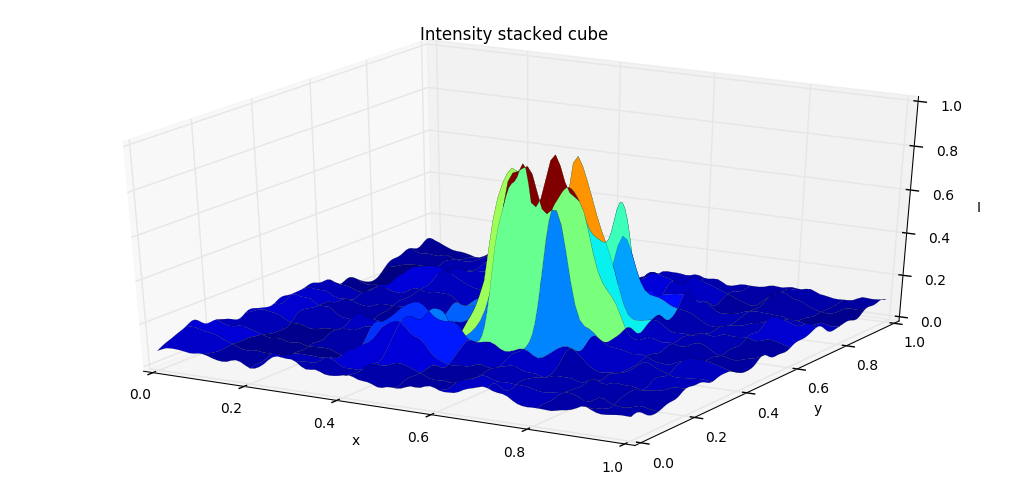

In [3]:
X,Y = np.meshgrid(x,y,sparse=True)
#3d plot
fig = plt.figure(figsize=(13,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, data, linewidth=0.1, cmap='jet')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('I')
plt.title('Intensity stacked cube')
plt.show()

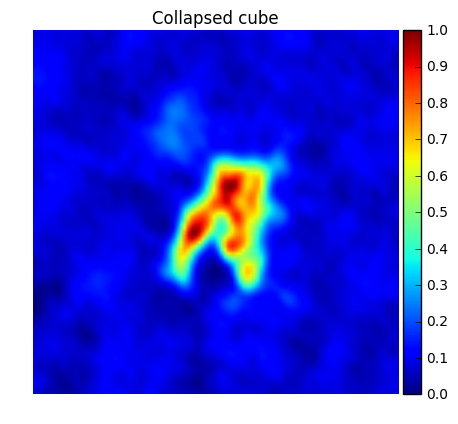

In [4]:
plt.figure(figsize=(5,5))
im = plt.imshow(data)
plt.title('Collapsed cube')
plt.axis('off')
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

## Euler-Lagrange Derivation

Given the following functional: 

$$J(u) = \int_{\Omega \subset \mathbb{R}} L(x, y, u, u_x, u_y) \ d\Omega  = \int_{\Omega \subset \mathbb{R}}(u(x,y)-f_0(x,y))^2 + \alpha \ \Psi_1(u(x,y)-f_0(x,y)) + \beta \ \Psi_2(\left|\nabla u(x,y)\right|^2) \ d\Omega $$

then when we try to minimize it, the corresponding Euler-Lagrange equation becomes:

$$
\frac{\partial L}{\partial u}-\frac{d}{dx}\frac{\partial L}{\partial u_x} - \frac{d}{dy}\frac{\partial L}{\partial u_y}= 0$$

$$
2(u-f) + \alpha \Psi_1'(u-f) -2\beta \Big( 2\Psi_2''(u_x^2+u_y^2) \left[(u_x u_{xx} + u_y u_{yx})u_x + (u_x u_{xy} + u_y u_{yy})u_y \right] + \Psi_2'(u_x^2 + u_y^2) \left[u_{xx}+u_{yy} \right] \Big) = 0
$$

whit boundary condition $u(\partial \Omega) = f(\partial \Omega)$. The proposed solution has the form of a linear combination of Gaussian functions:

$$u(x,y) = \sum_{i=1}^N c_i \ \phi(x, y;\ x_i, \sigma_i) = \sum_{i=1}^N c_i \ e^{-\frac{(x-x_i)^2 + (y-y_i)^2}{2 \sigma_i^2}}$$

## Centers and evaluation points

#### Thresholded data: Over the RMS value.

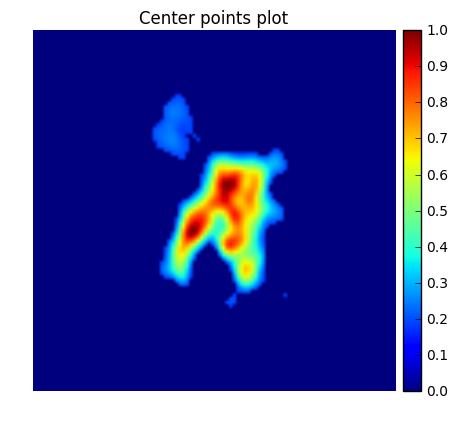

In [5]:
plt.figure(figsize=(5,5))
ax = plt.gca()
_data = np.zeros(data.shape)
mask = data > estimate_rms(data)
_data[mask] = data[mask]
im = ax.imshow(_data)
plt.title('Center points plot')
plt.axis('off')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.08)
plt.colorbar(im, cax=cax)
plt.show()

In [3]:
"""
Boundary points
"""
#number of boundary points by side
Nb = 0
Nc = 500
Ne = 2*Nc-4*Nb

boundary_points = boundary_generation(Nb)

In [7]:
cut_value = acalib.rms(data)/2

In [8]:
center_points = random_centers_generation(data, Nc, cut_value_leq=cut_value)
extra_points = random_centers_generation(data, Ne, cut_value_geq=cut_value)
collocation_points = np.vstack((center_points, extra_points))

### Visualization of points

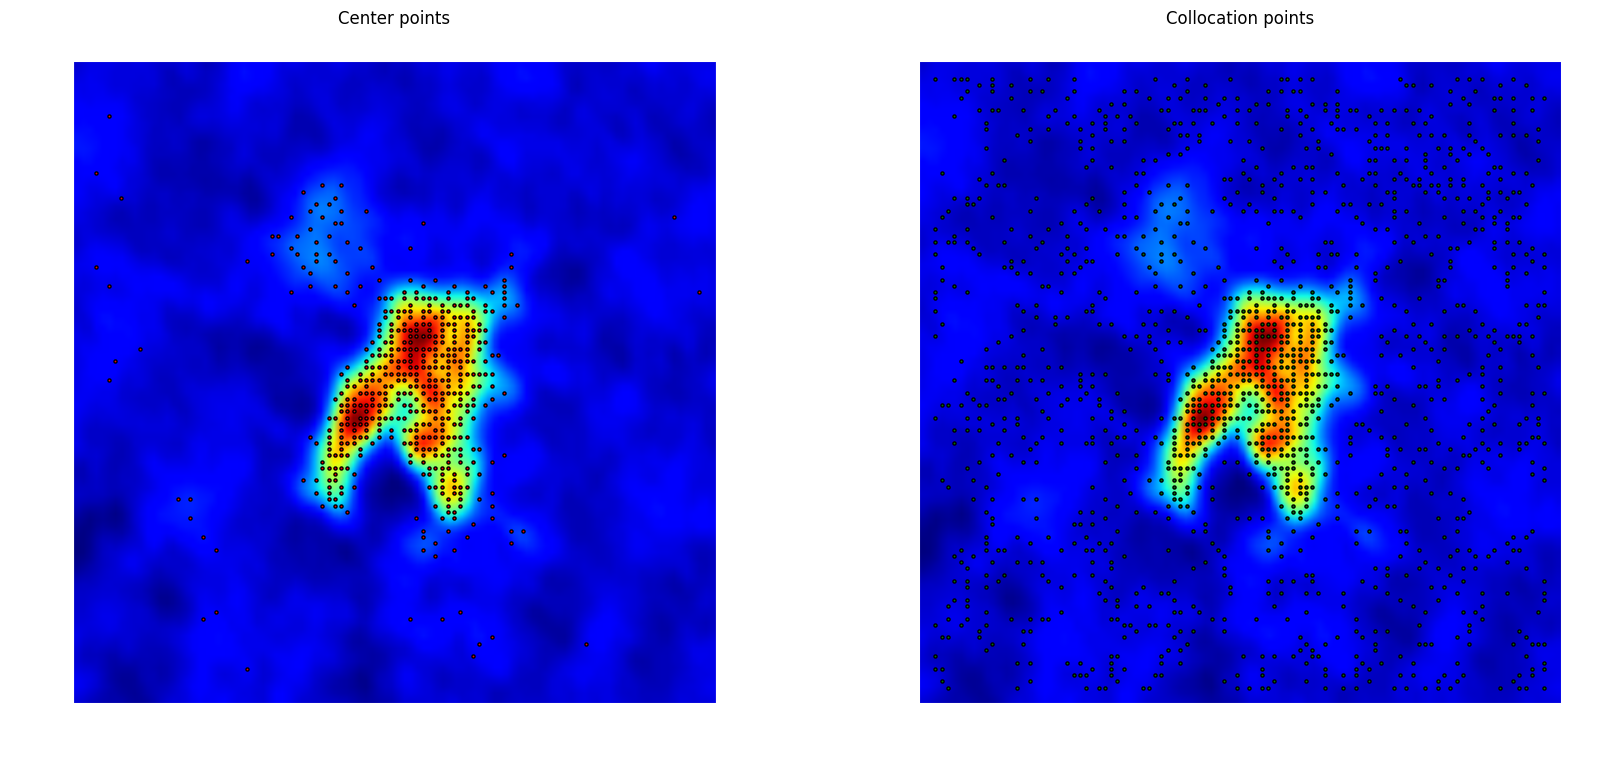

In [9]:
points_plot(data, center_points=center_points, collocation_points=collocation_points)

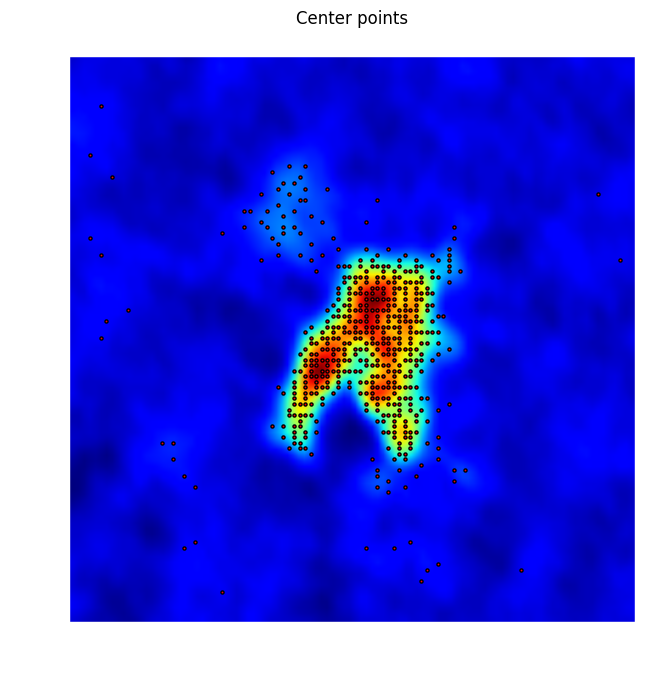

In [10]:
points_plot(data, center_points=center_points)

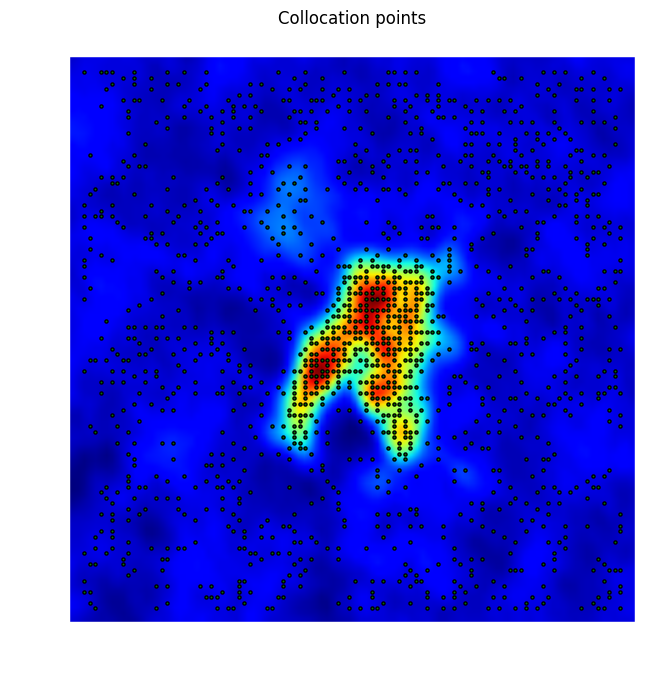

In [11]:
points_plot(data, collocation_points=collocation_points)

In [12]:
points_plot(data, boundary_points=boundary_points)

In [13]:
xc = center_points[:,0]
yc = center_points[:,1]
xe = collocation_points[:,0]
ye = collocation_points[:,1]
xb = boundary_points[:,0]
yb = boundary_points[:,1]

## Initial Conditions

In [14]:
"""
Initial parameters estimation
"""
#c0, sig0 = estimate_initial_guess(center_points, f, R=0.009, method='mean_dist')
c0, sig0 = estimate_initial_guess(center_points, dfunc, minsig=minsig, method='min_dist')

## Visualizing the initial solution

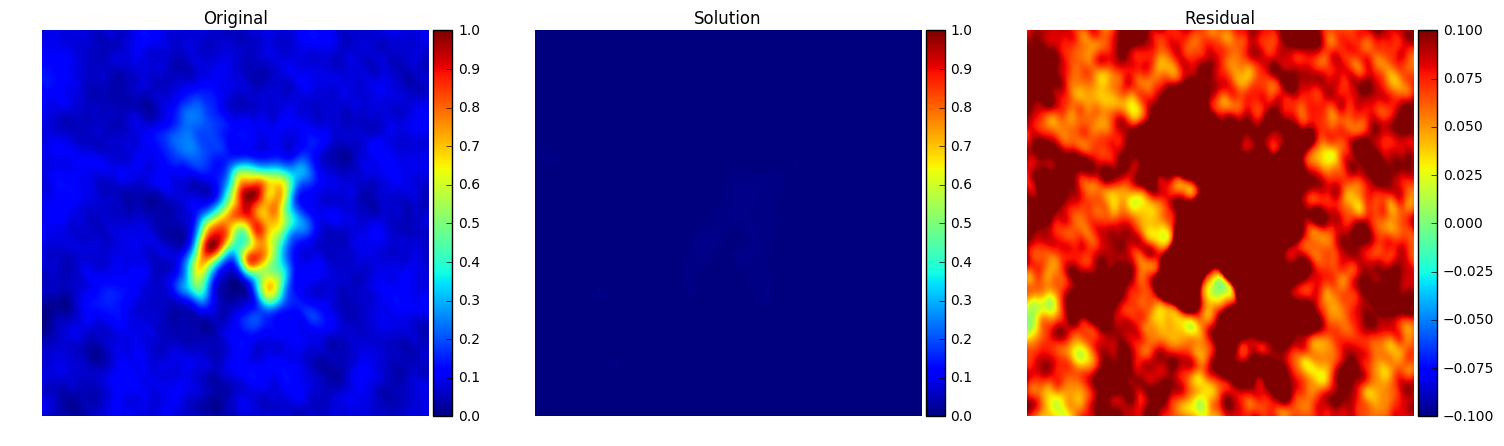

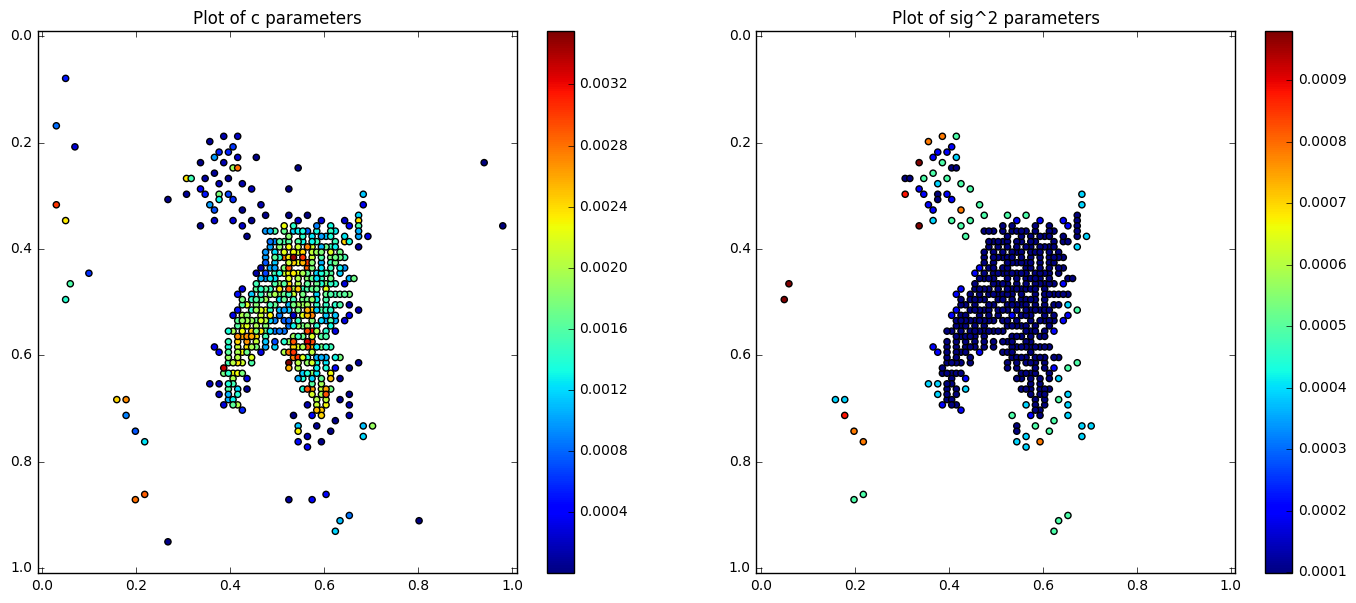

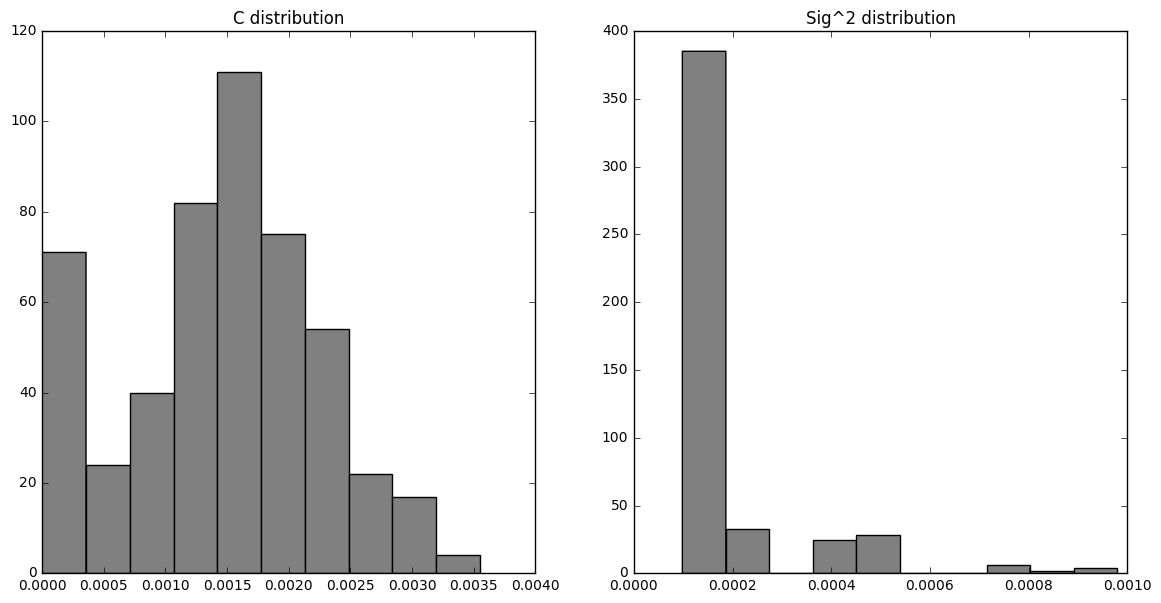

In [15]:
#plot_sol(c0, sig0, xc, yc, base_level=estimate_rms(data))
solution_plot(dfunc, c0, sig0, xc, yc, dims=data.shape, base_level=0., compact_supp=False)
params_plot(c0, sig0, xc, yc, square_c=True)
params_distribution_plot(c0, sig0, square_c=True)

# Experiments 1: With  `base_level=0`
The following instances are tests with different settings combinations for: square_c and support

In [16]:
"""
ELFunc instantiations
"""

elf01 = ELFunc(dfunc, data.shape, xe, ye, xc, yc, xb, yb, np.sqrt(c0), sig0, a=1., lamb1=1., d1psi1=d1psi, d1psi2=d1psi,
              d2psi2=d2psi, base_level=0., square_c=True, compact_supp=False)


elf02 = ELFunc(dfunc, data.shape, xe, ye, xc, yc, xb, yb, c0, sig0, a=1., lamb1=1., d1psi1=d1psi, d1psi2=d1psi,
              d2psi2=d2psi, base_level=0., square_c=False, compact_supp=False)

### C-squared and no compact support


##########################################################################################
Results after 2000 iterations
##########################################################################################
Variation on c = 0.769658023914
variation on sig = 1.42310203102

success: False

status: 5

message: Number of calls to function has reached maxfev = 2000.

nfev: 2006

##########################################################################################
Results after 4000 iterations
##########################################################################################
Variation on c = 0.320608829017
variation on sig = 3.40573725435

success: False

status: 5

message: Number of calls to function has reached maxfev = 2000.

nfev: 2006

##########################################################################################
Results after 6000 iterations
##########################################################################################
Variation on c = 0.2533

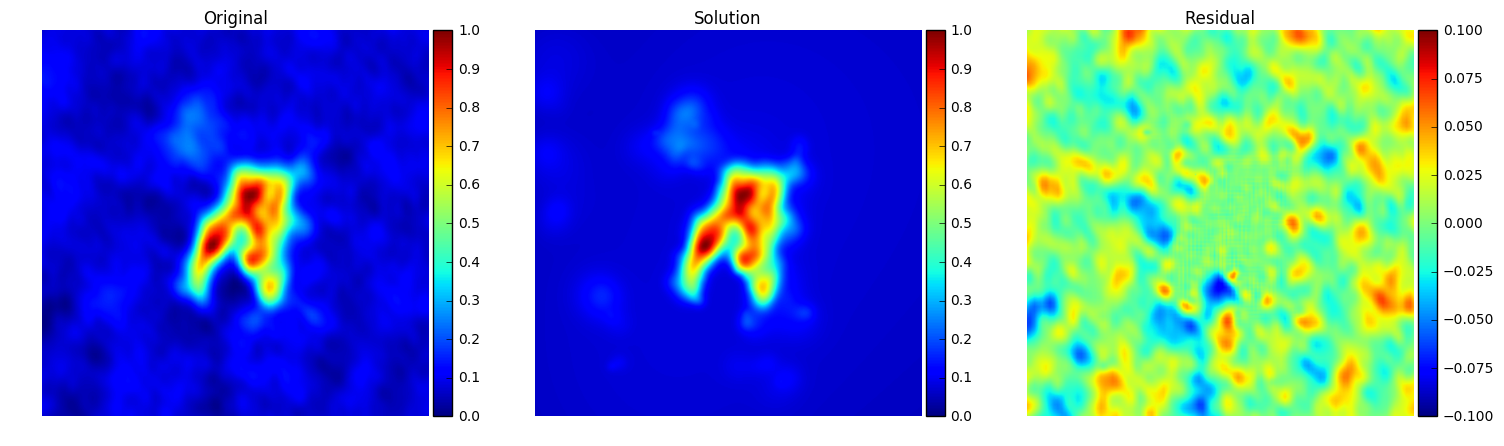

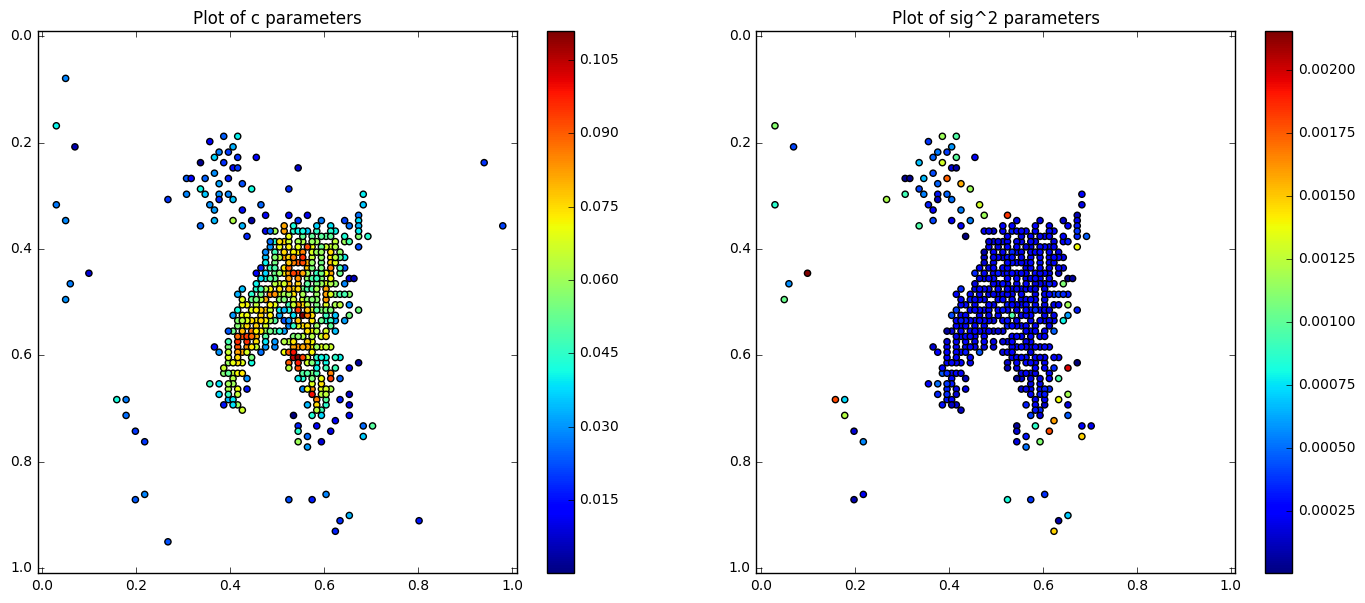

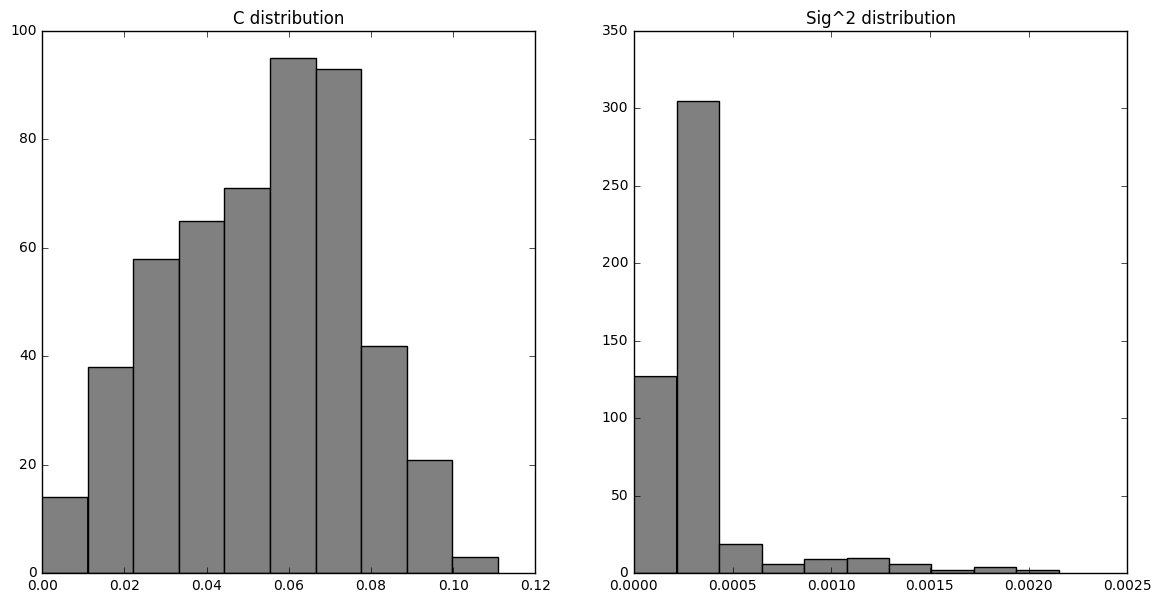

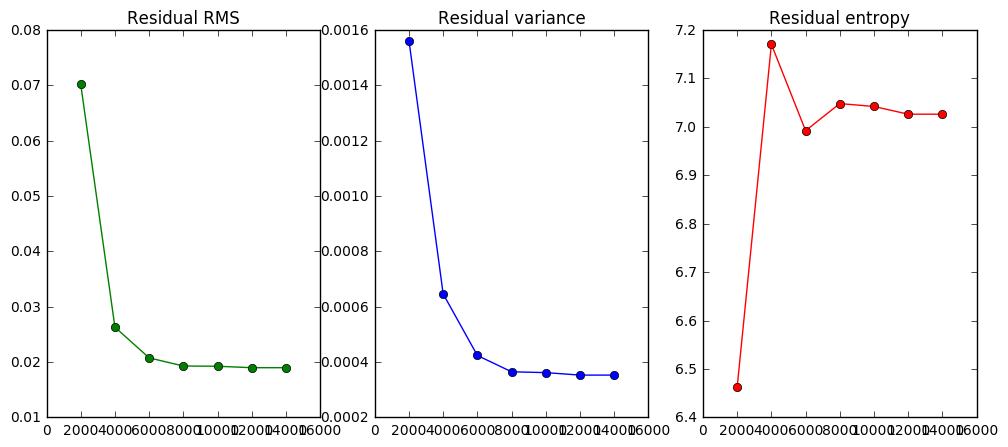

In [17]:
el_solver(elf01, method='exact', base_level=0., square_c=True, step_iter=2000, max_iter=50000)

### C-not squared and no compact support


##########################################################################################
Results after 2000 iterations
##########################################################################################
Variation on c = 0.216119804485
variation on sig = 1.09115374318

success: False

status: 5

message: Number of calls to function has reached maxfev = 2000.

nfev: 2006

##########################################################################################
Results after 4000 iterations
##########################################################################################
Variation on c = 0.291029600469
variation on sig = 2.79412544826

success: False

status: 5

message: Number of calls to function has reached maxfev = 2000.

nfev: 2006

##########################################################################################
Results after 6000 iterations
##########################################################################################
Variation on c = 0.1516

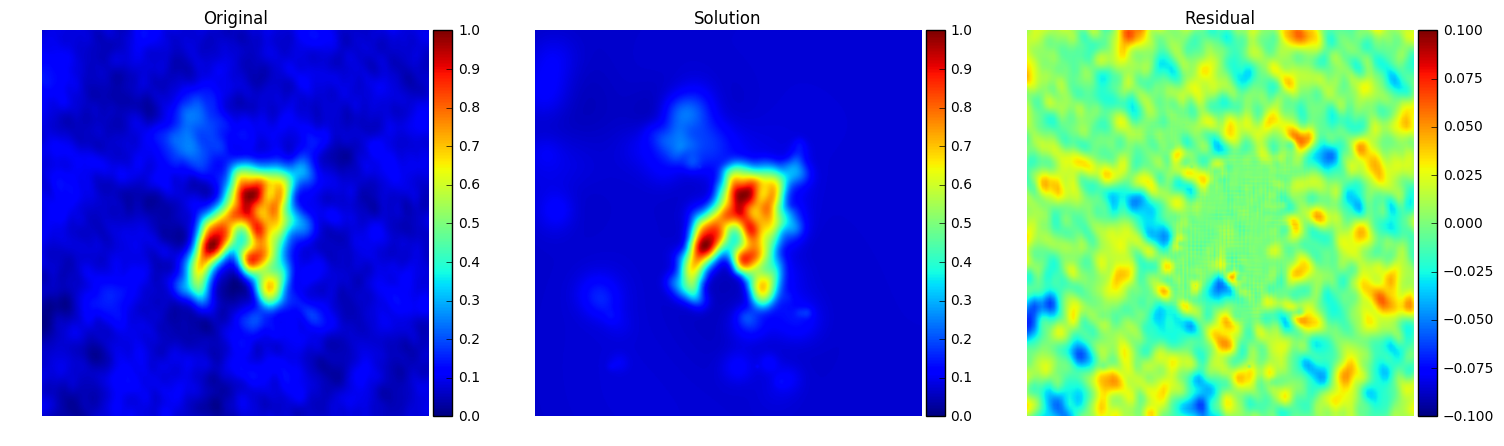

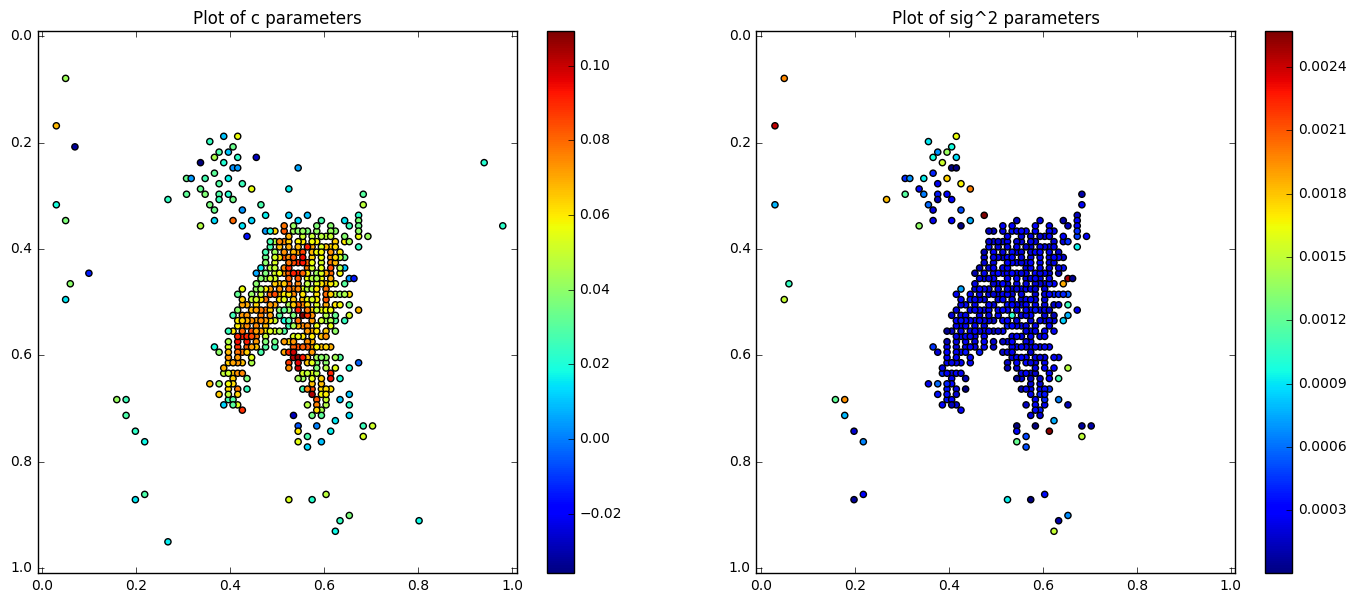

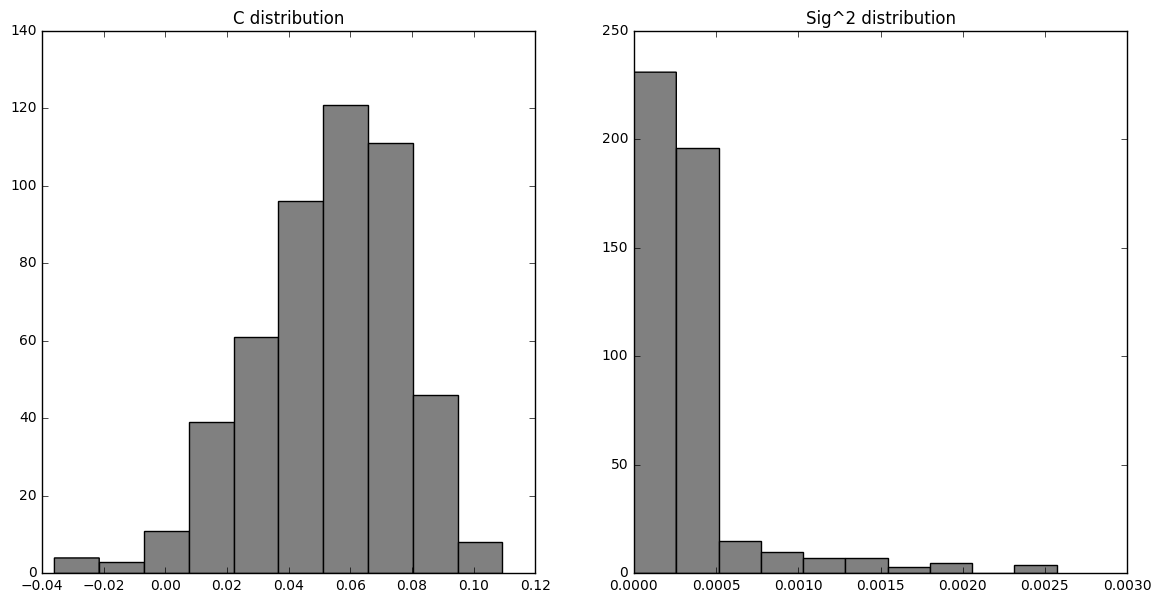

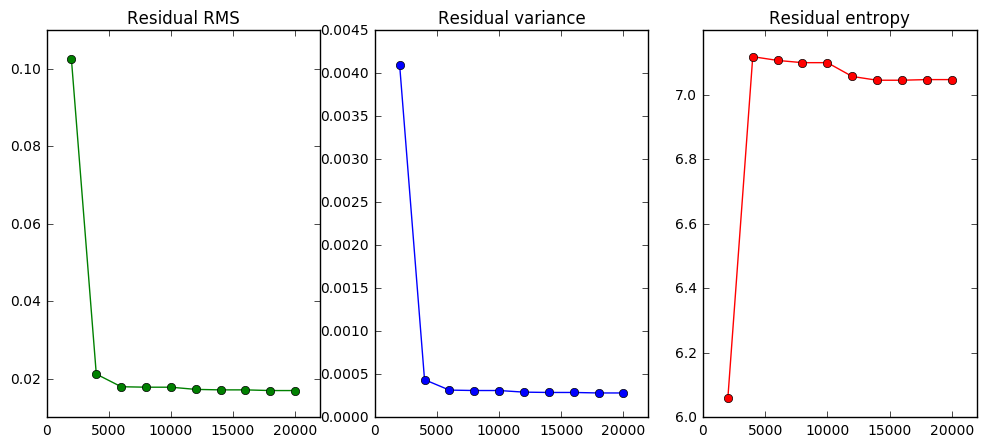

In [18]:
el_solver(elf02, method='exact', base_level=0., square_c=False, step_iter=2000, max_iter=50000)

# Adding the smoothing effect

In [19]:
"""
ELFunc instantiations
"""

elf03 = ELFunc(dfunc, data.shape, xe, ye, xc, yc, xb, yb, np.sqrt(c0), sig0, a=1., lamb1=1., b=0.001, lamb2=1., 
               d1psi1=d1psi, d1psi2=d1psi, d2psi2=d2psi, base_level=0., square_c=True, compact_supp=False)


elf04 = ELFunc(dfunc, data.shape, xe, ye, xc, yc, xb, yb, np.sqrt(c0), sig0, a=1., lamb1=1., b=0.0001, lamb2=1.,
               d1psi1=d1psi, d1psi2=d1psi, d2psi2=d2psi, base_level=0., square_c=True, compact_supp=False)


##########################################################################################
Results after 2000 iterations
##########################################################################################
Variation on c = 0.420292850953
variation on sig = 0.126101702095

success: False

status: 5

message: Number of calls to function has reached maxfev = 2000.

nfev: 2008

##########################################################################################
Results after 4000 iterations
##########################################################################################
Variation on c = 0.00128185602808
variation on sig = 9.40567614955e-05

success: False

status: 5

message: Number of calls to function has reached maxfev = 2000.

nfev: 2012

##########################################################################################
Results after 6000 iterations
##########################################################################################
Variation on c =

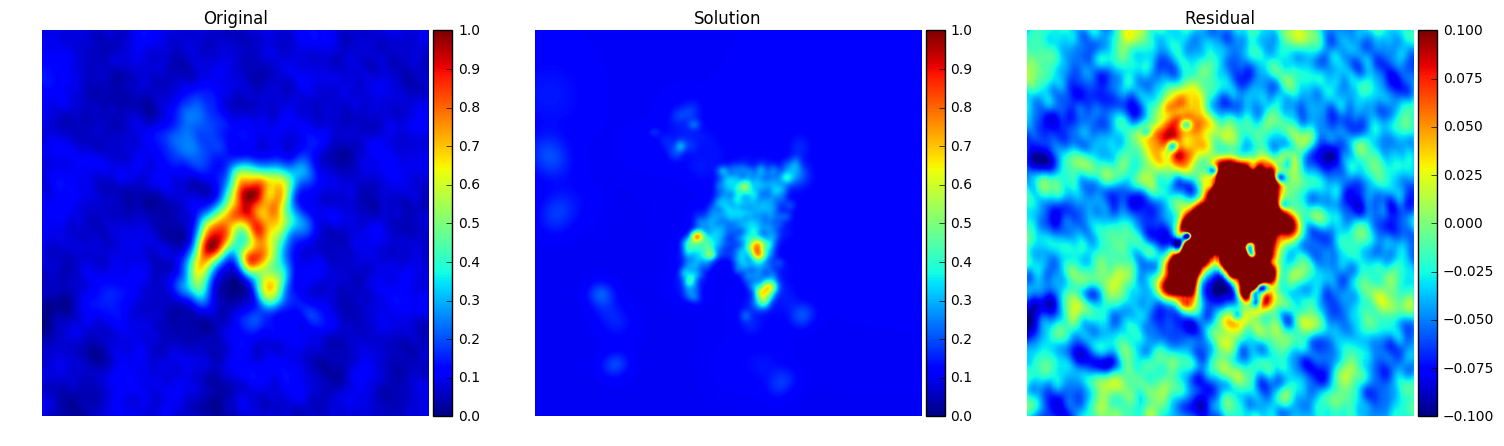

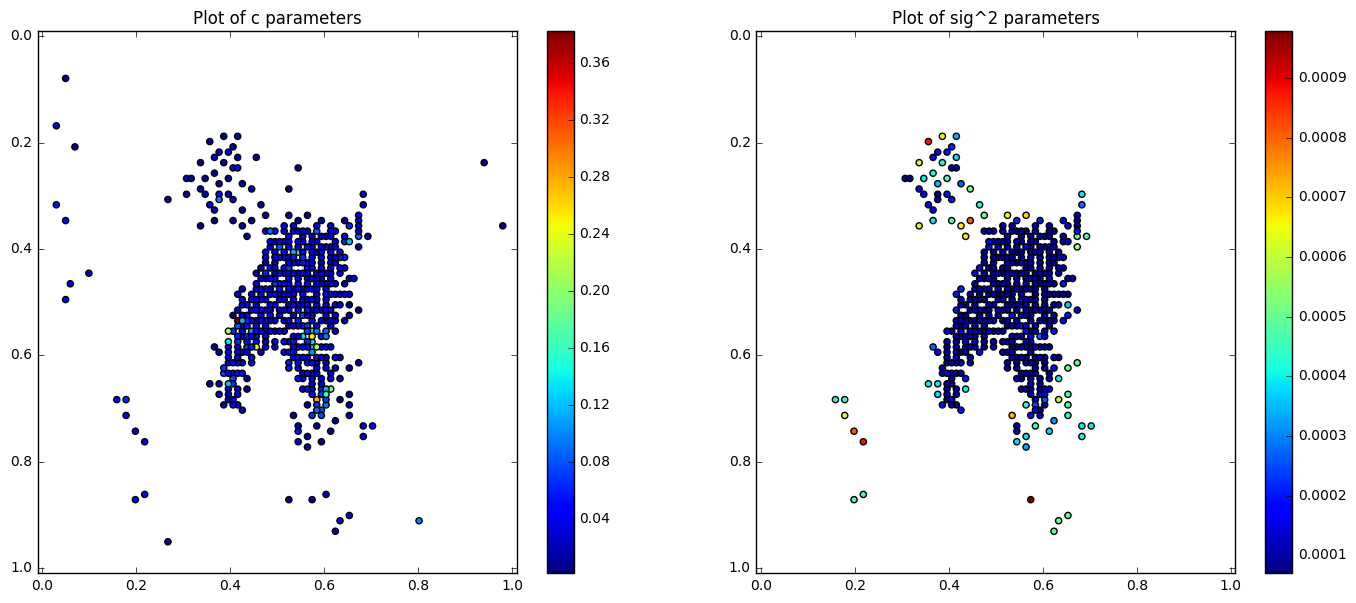

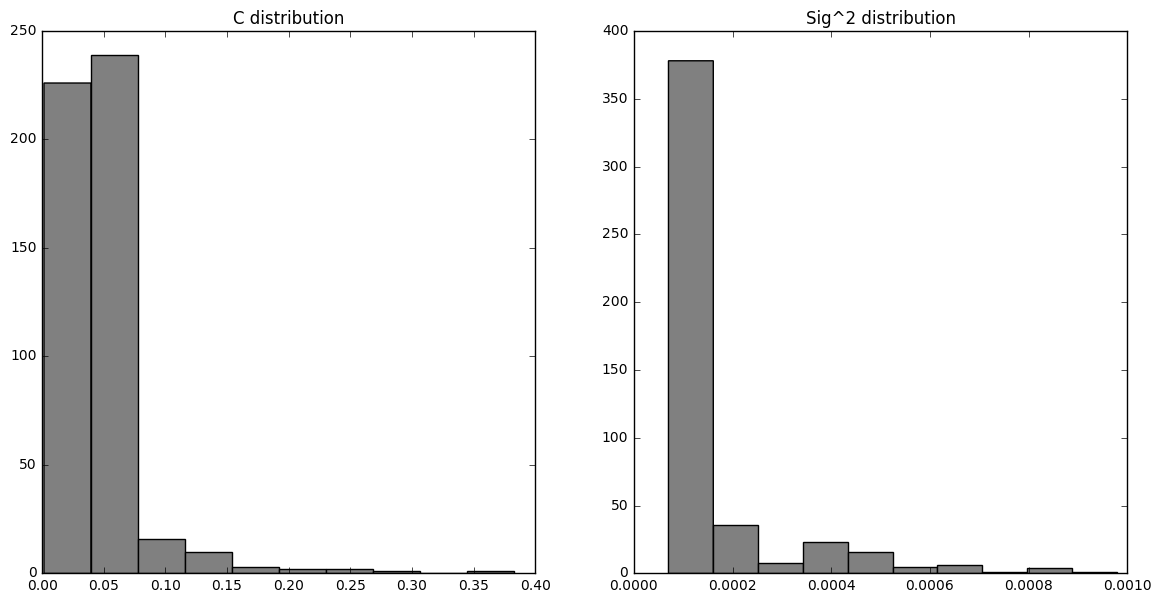

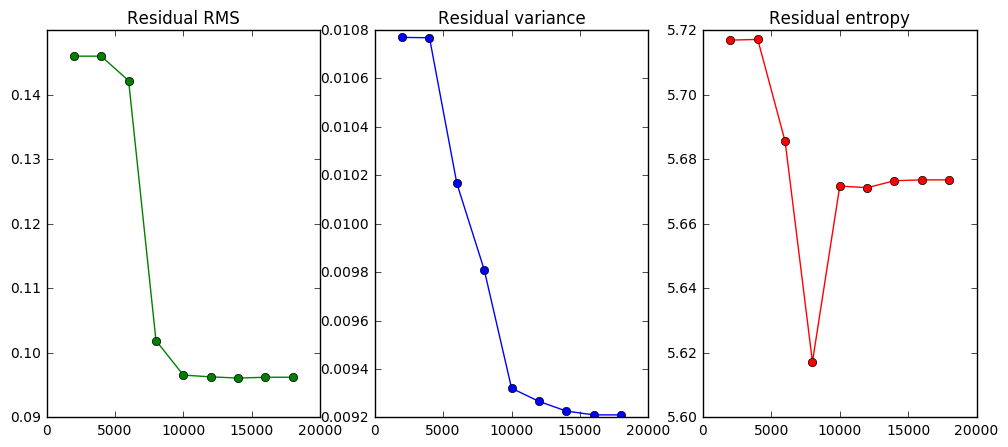

In [20]:
el_solver(elf03, method='exact', base_level=0., square_c=True, step_iter=2000, max_iter=50000)


##########################################################################################
Results after 2000 iterations
##########################################################################################
Variation on c = 1.00787953407
variation on sig = 3.31300469761

success: False

status: 5

message: Number of calls to function has reached maxfev = 2000.

nfev: 2007

##########################################################################################
Results after 4000 iterations
##########################################################################################
Variation on c = 1.10749635424
variation on sig = 2.62822686169

success: False

status: 5

message: Number of calls to function has reached maxfev = 2000.

nfev: 2007

##########################################################################################
Results after 6000 iterations
##########################################################################################
Variation on c = 0.642596

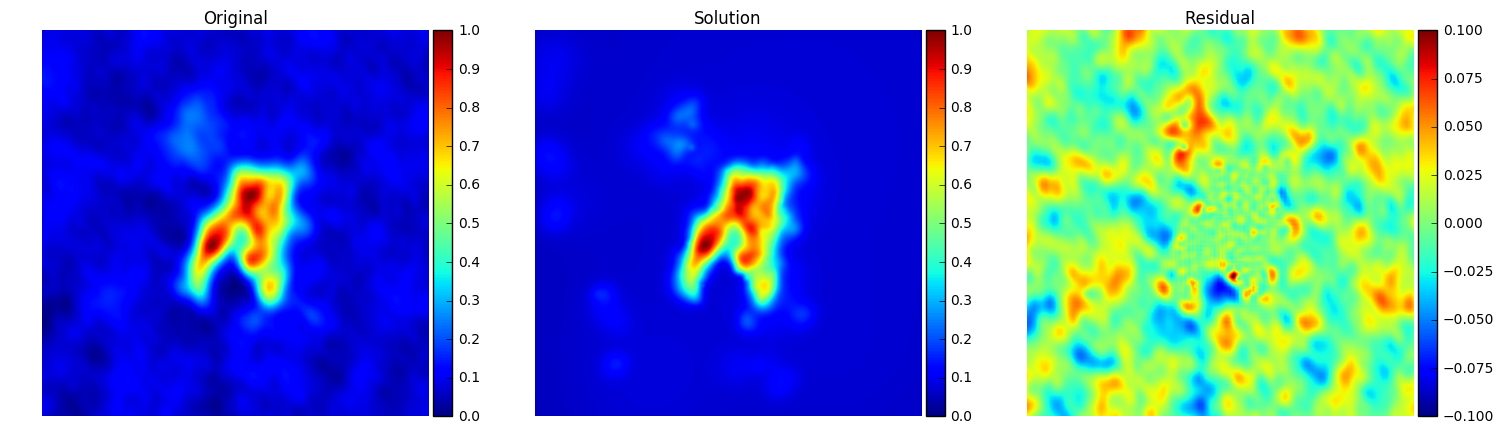

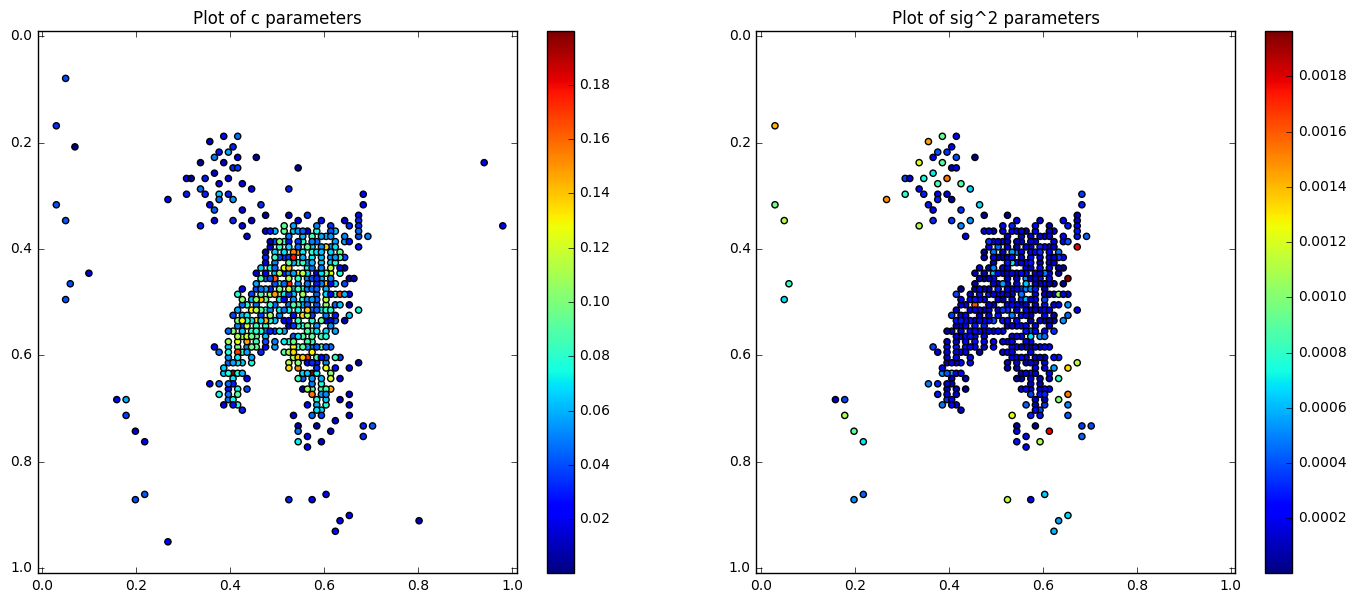

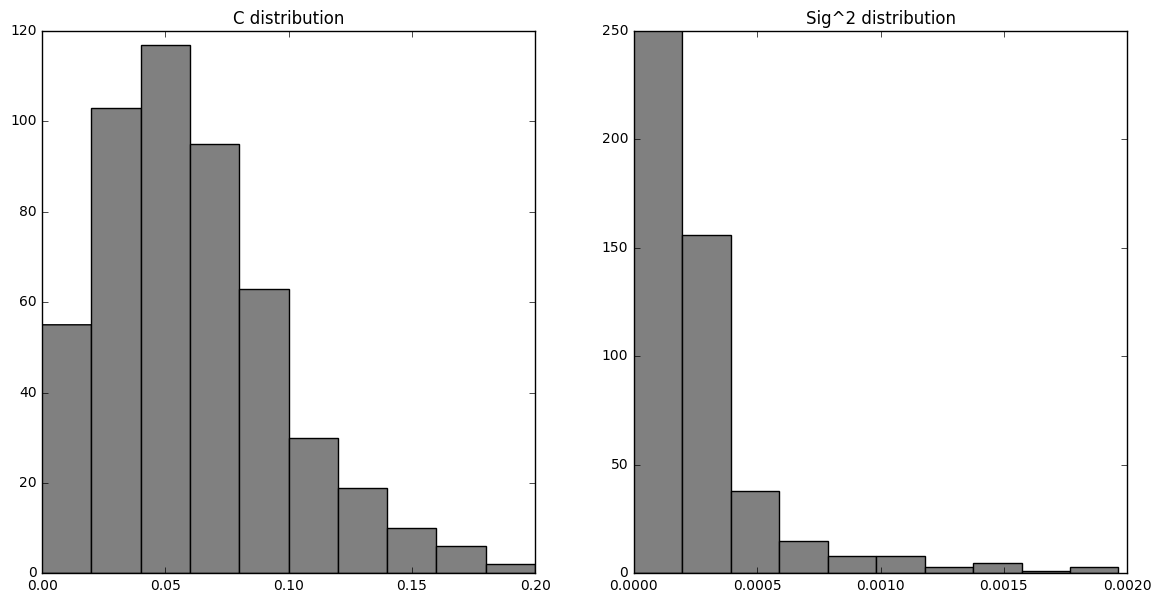

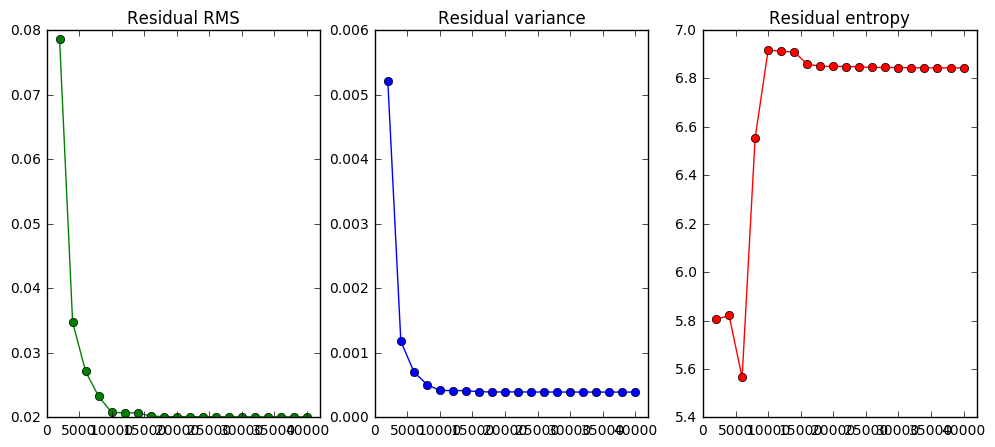

In [21]:
el_solver(elf04, method='exact', base_level=0., square_c=True, step_iter=2000, max_iter=50000)

## Greater penalty on flux addition term

In [22]:
"""
ELFunc instantiations
"""

elf05 = ELFunc(dfunc, data.shape, xe, ye, xc, yc, xb, yb, np.sqrt(c0), sig0, a=5., lamb1=1., b=0., lamb2=1.,
               d1psi1=d1psi, d1psi2=d1psi, d2psi2=d2psi, base_level=0., square_c=True, compact_supp=False)

elf06 = ELFunc(dfunc, data.shape, xe, ye, xc, yc, xb, yb, np.sqrt(c0), sig0, a=1., lamb1=5., b=0., lamb2=1.,
               d1psi1=d1psi, d1psi2=d1psi, d2psi2=d2psi, base_level=0., square_c=True, compact_supp=False)

elf07 = ELFunc(dfunc, data.shape, xe, ye, xc, yc, xb, yb, np.sqrt(c0), sig0, a=5., lamb1=5., b=0., lamb2=1.,
               d1psi1=d1psi, d1psi2=d1psi, d2psi2=d2psi, base_level=0., square_c=True, compact_supp=False)


##########################################################################################
Results after 2000 iterations
##########################################################################################
Variation on c = 0.769658023914
variation on sig = 1.42310203102

success: False

status: 5

message: Number of calls to function has reached maxfev = 2000.

nfev: 2006

##########################################################################################
Results after 4000 iterations
##########################################################################################
Variation on c = 0.385813891962
variation on sig = 3.48548509277

success: False

status: 5

message: Number of calls to function has reached maxfev = 2000.

nfev: 2006

##########################################################################################
Results after 6000 iterations
##########################################################################################
Variation on c = 0.2284

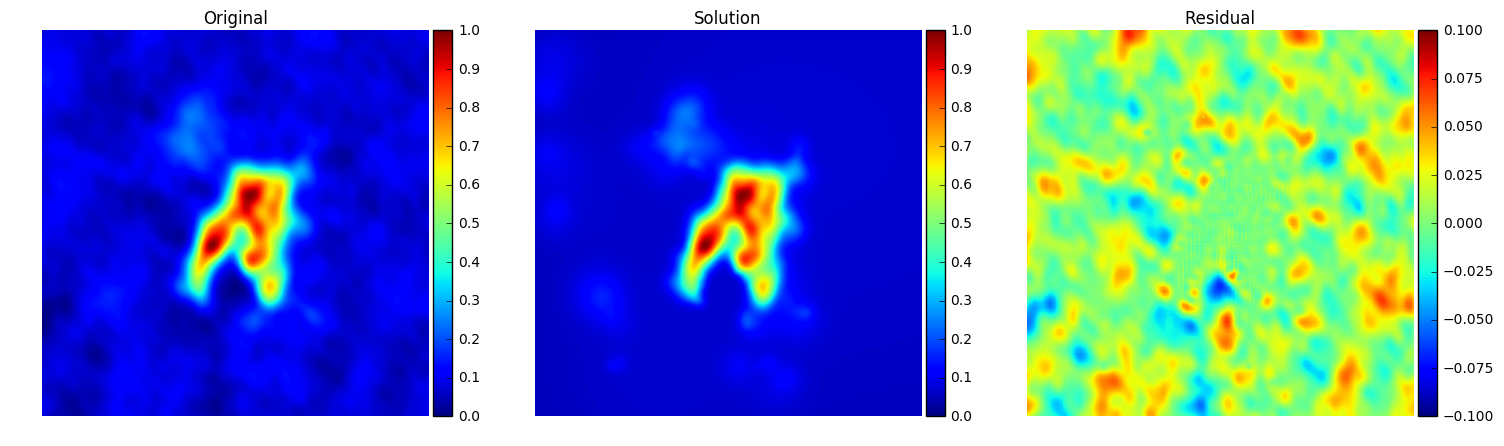

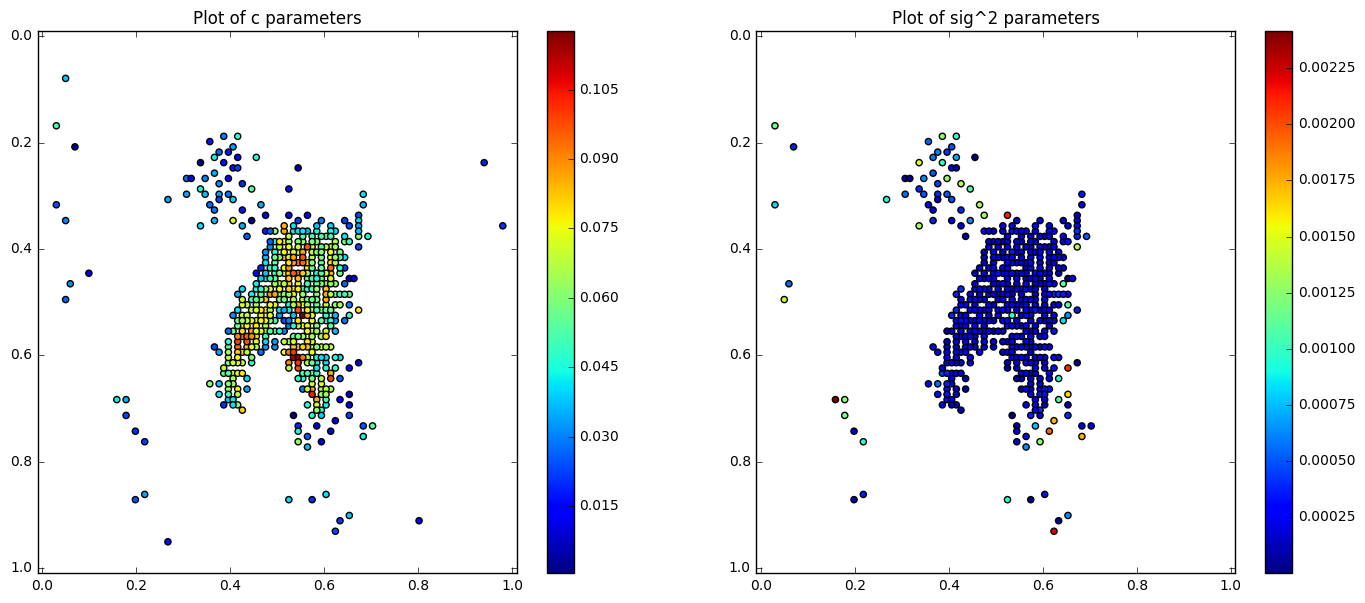

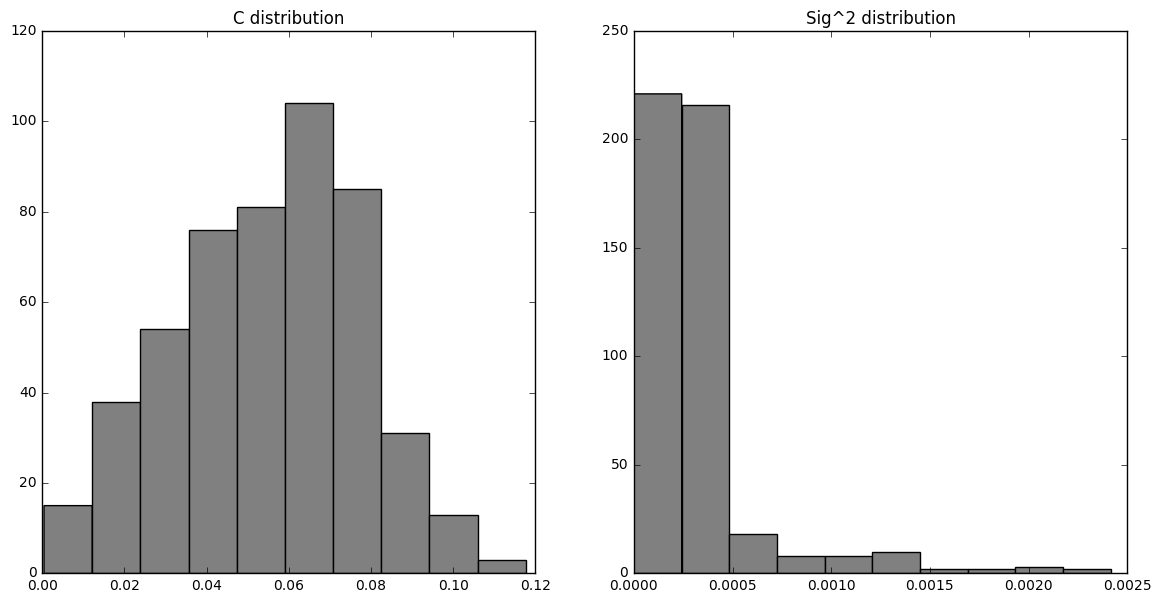

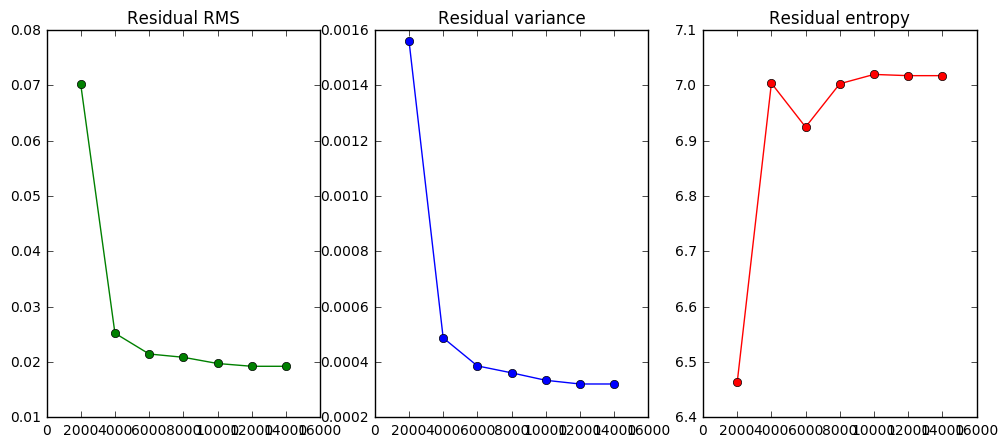

In [23]:
el_solver(elf05, method='exact', base_level=0., square_c=True, step_iter=2000, max_iter=50000)


##########################################################################################
Results after 2000 iterations
##########################################################################################
Variation on c = 0.769658023914
variation on sig = 1.42310203102

success: False

status: 5

message: Number of calls to function has reached maxfev = 2000.

nfev: 2006

##########################################################################################
Results after 4000 iterations
##########################################################################################
Variation on c = 0.14614071095
variation on sig = 0.152431806839

success: False

status: 5

message: Number of calls to function has reached maxfev = 2000.

nfev: 2007

##########################################################################################
Results after 6000 iterations
##########################################################################################
Variation on c = 0.0313

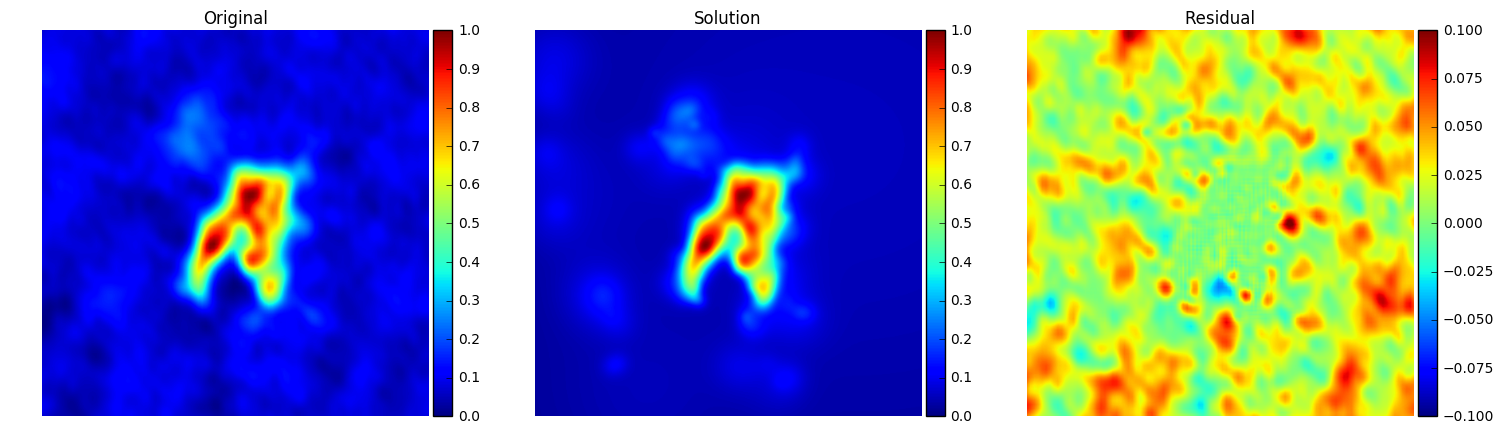

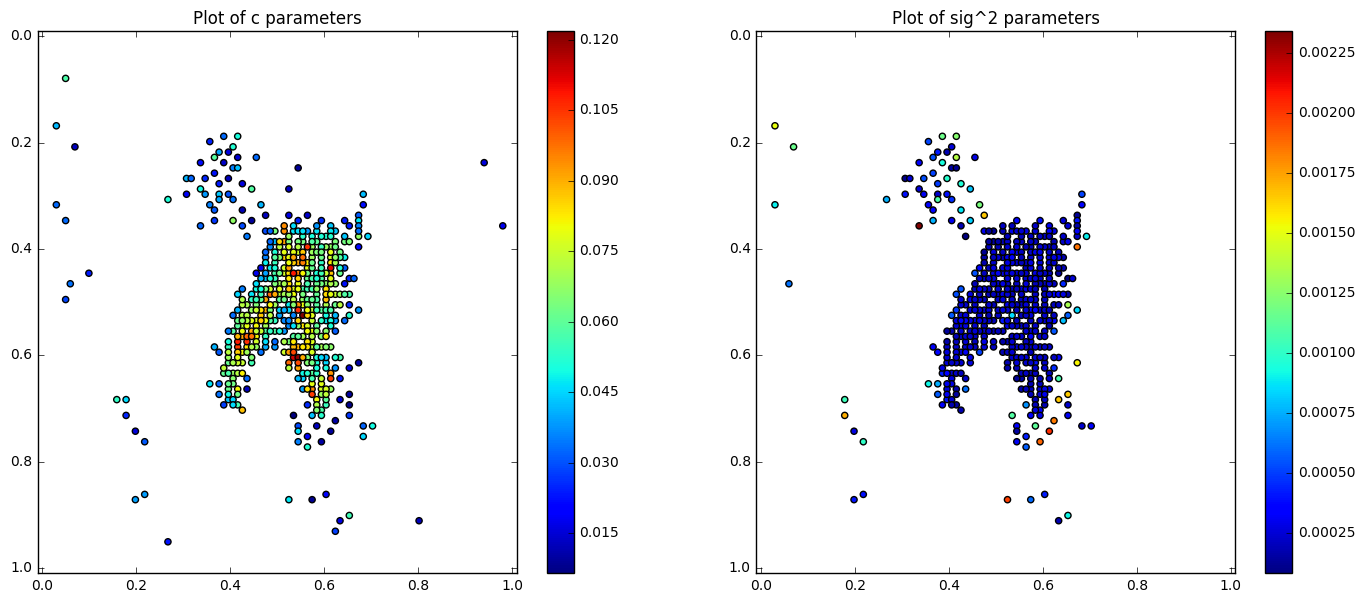

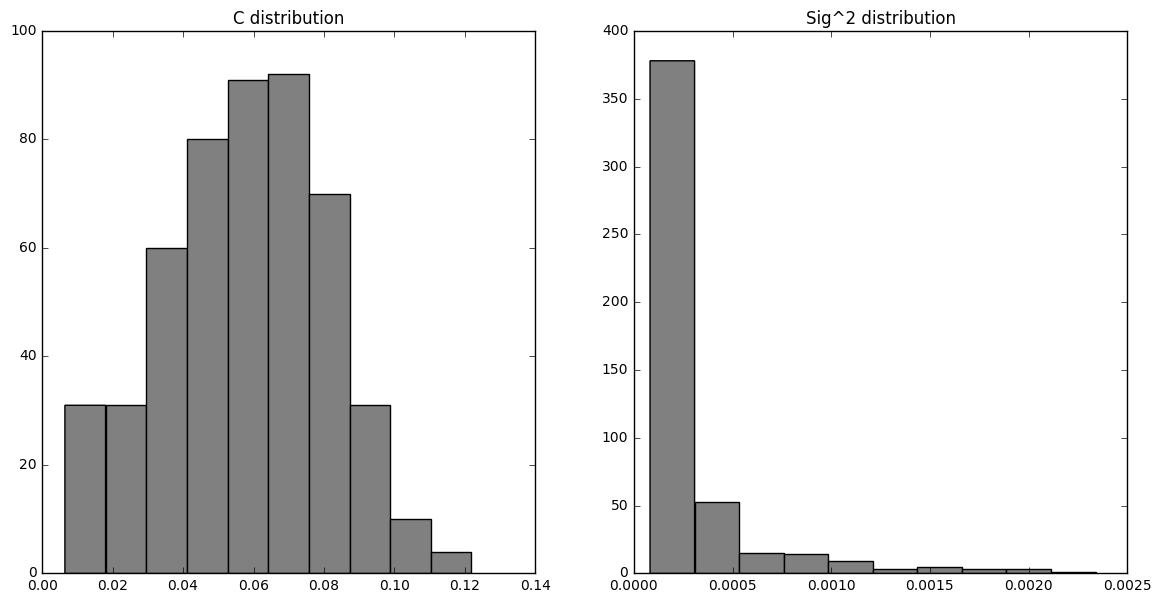

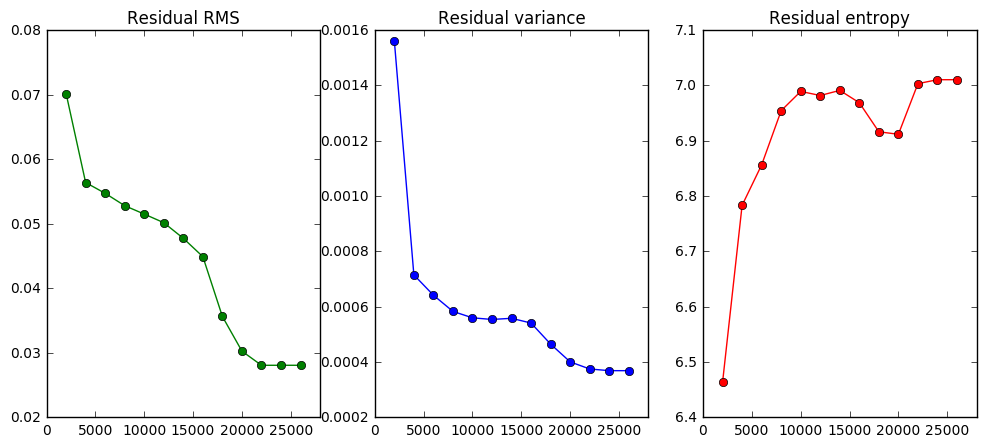

In [24]:
el_solver(elf06, method='exact', base_level=0., square_c=True, step_iter=2000, max_iter=50000)


##########################################################################################
Results after 2000 iterations
##########################################################################################
Variation on c = 0.769658023914
variation on sig = 1.42310203102

success: False

status: 5

message: Number of calls to function has reached maxfev = 2000.

nfev: 2006

##########################################################################################
Results after 4000 iterations
##########################################################################################
Variation on c = 0.0611791908479
variation on sig = 0.0119369143042

success: False

status: 5

message: Number of calls to function has reached maxfev = 2000.

nfev: 2008

##########################################################################################
Results after 6000 iterations
##########################################################################################
Variation on c = 0.0

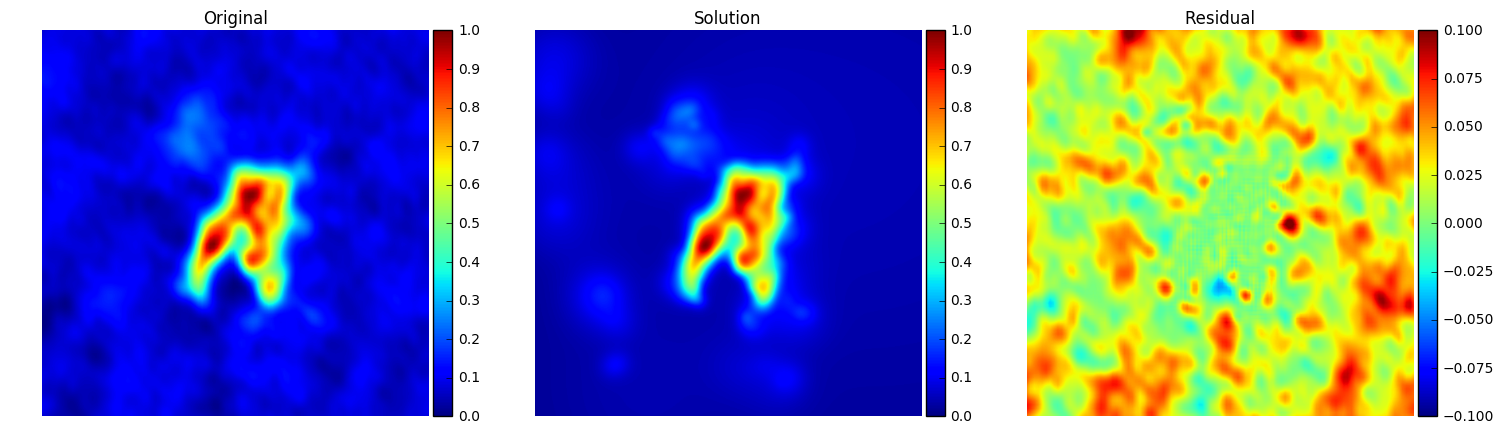

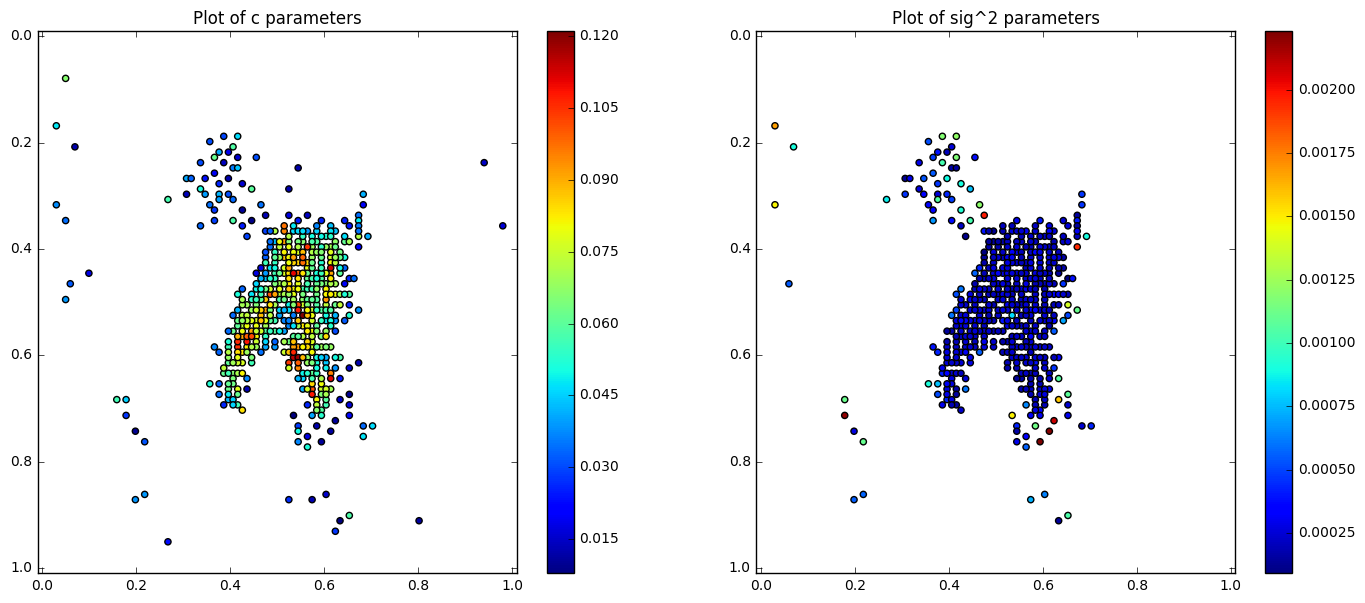

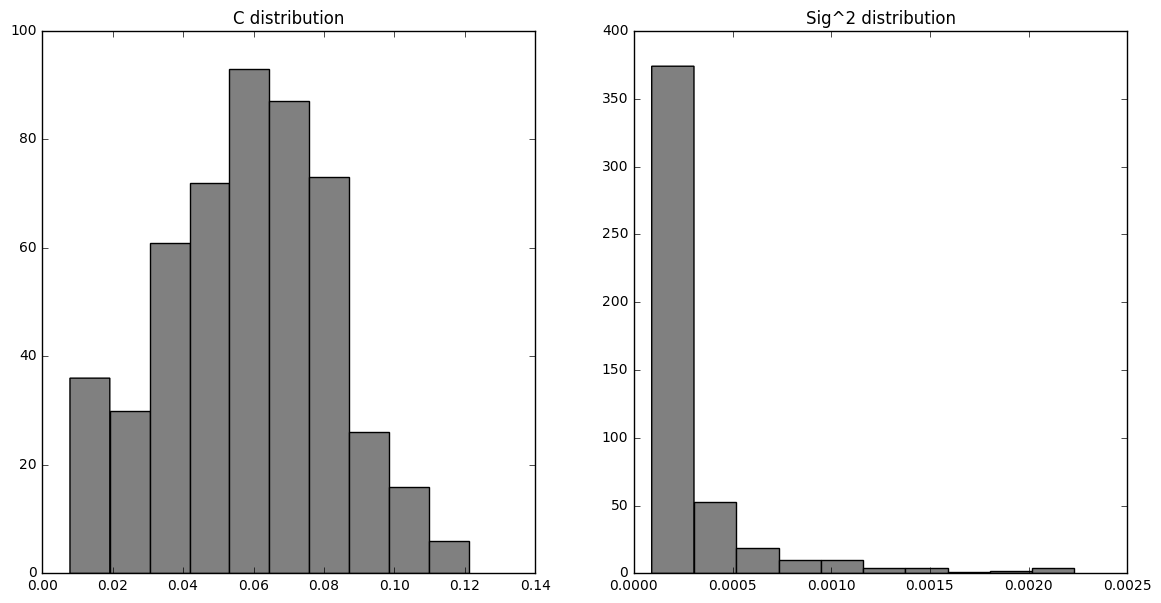

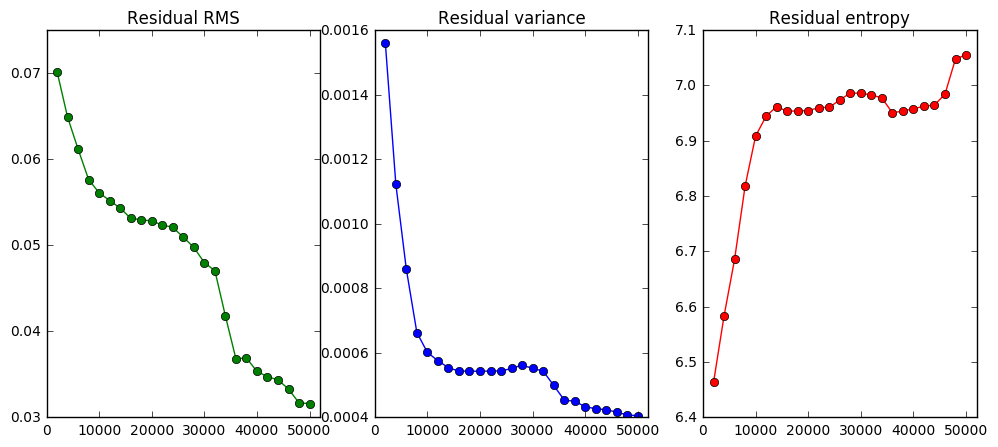

In [25]:
el_solver(elf07, method='exact', base_level=0., square_c=True, step_iter=2000, max_iter=50000)

# Experiments 2: With  `base_level=RMS`

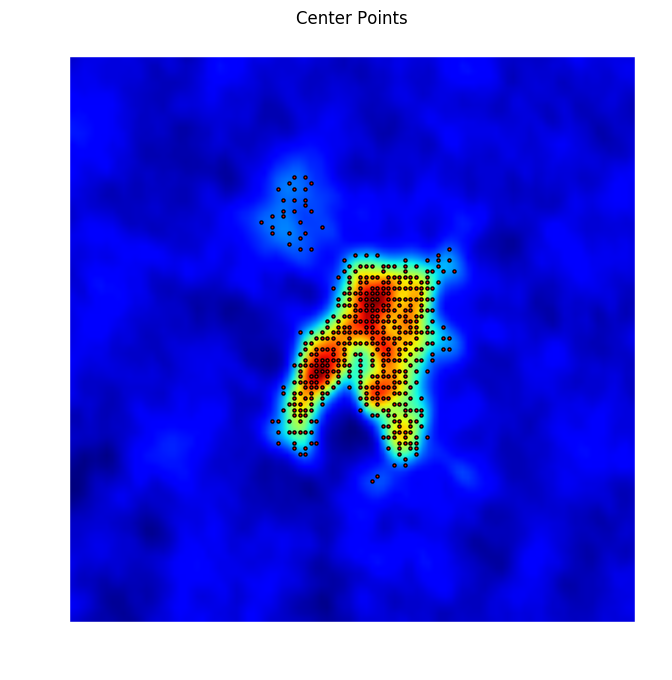

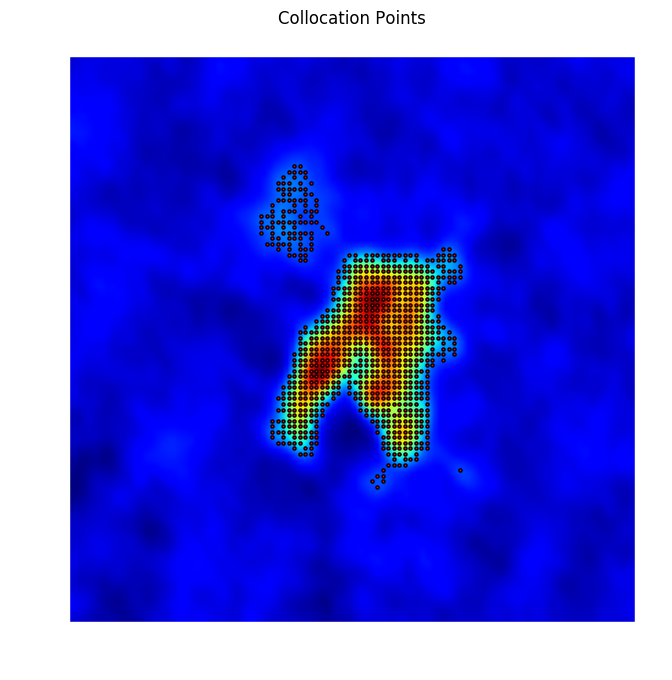

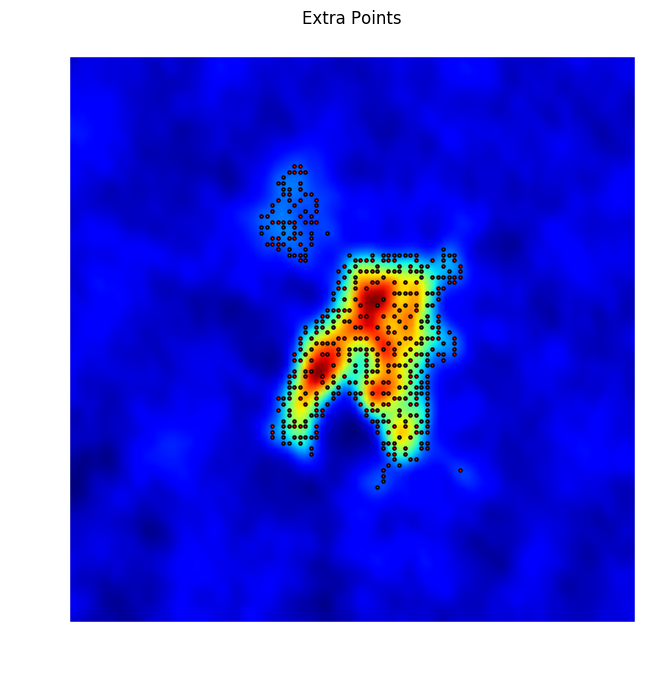

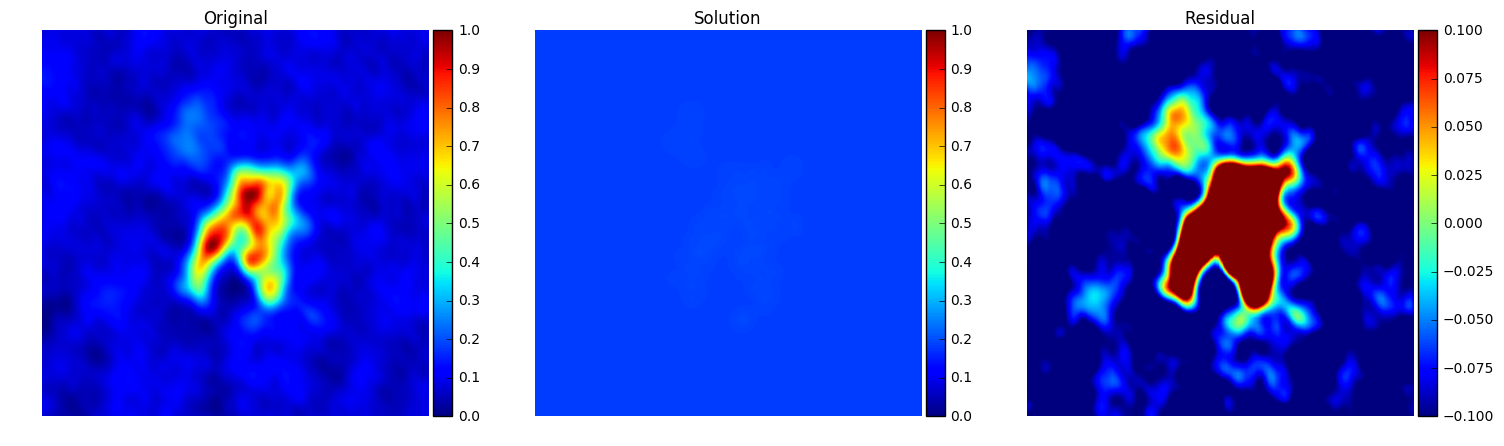

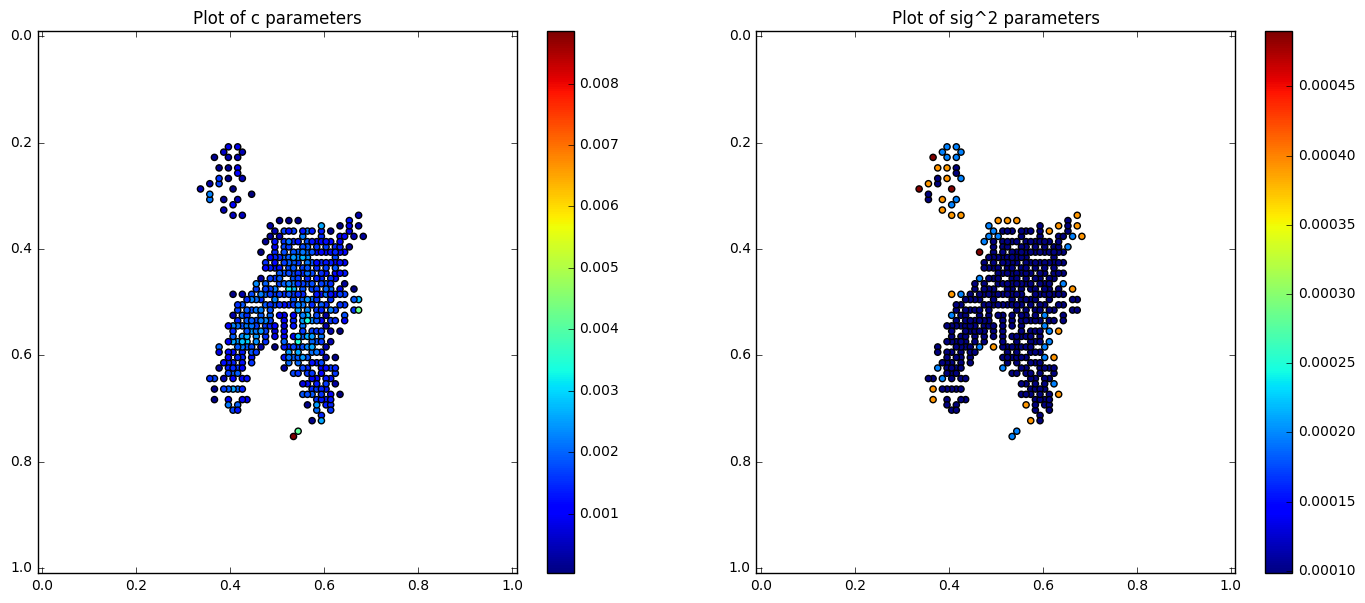

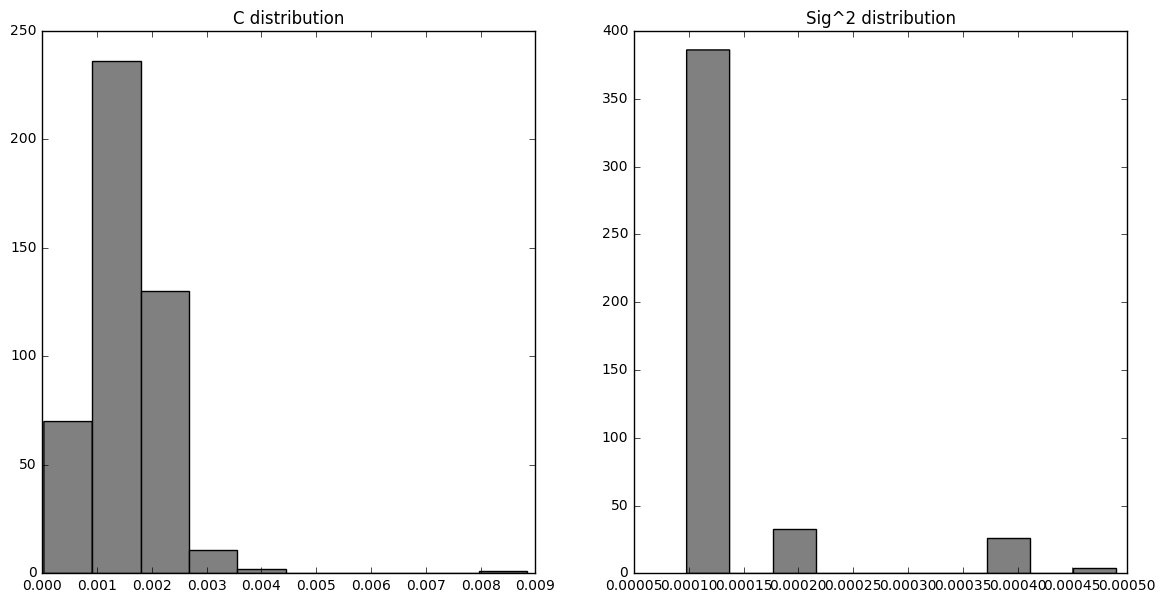

In [4]:
Nc = 450
base_level = estimate_rms(data)

centers = random_centers_generation(data, 2*Nc, cut_value_leq=base_level)
center_points = centers[0:Nc]
collocation_points = centers

# right formating
xc = center_points[:,0]
yc = center_points[:,1]
xe = collocation_points[:,0]
ye = collocation_points[:,1]
xb = boundary_points[:,0]
yb = boundary_points[:,1]


# visualizing the choosen points
points_plot(data, center_points=center_points, title="Center Points")
points_plot(data, center_points=collocation_points, title="Collocation Points")
points_plot(data, center_points=centers[Nc:], title="Extra Points")

# initial conditions
c0, sig0 = estimate_initial_guess(center_points, dfunc, minsig=minsig, method='min_dist')

# visualizing the initial solution
solution_plot(dfunc, c0, sig0, xc, yc, dims=data.shape, base_level=base_level, compact_supp=False)
params_plot(c0, sig0, xc, yc, square_c=True)
params_distribution_plot(c0, sig0, square_c=True)

In [5]:
"""
ELFunc instantiations
"""

elf08 = ELFunc(dfunc, data.shape, xe, ye, xc, yc, xb, yb, np.sqrt(c0), sig0, a=1., lamb1=1., d1psi1=d1psi, d1psi2=d1psi,
              d2psi2=d2psi, base_level=base_level, square_c=True, compact_supp=False)


##########################################################################################
Results after 2000 iterations
##########################################################################################
Variation on c = 0.823580326935
variation on sig = 0.123950641692

success: False

status: 5

message: Number of calls to function has reached maxfev = 2000.

nfev: 2707

##########################################################################################
Results after 4000 iterations
##########################################################################################
Variation on c = 0.976384692529
variation on sig = 0.175757136041

success: False

status: 5

message: Number of calls to function has reached maxfev = 2000.

nfev: 2707

##########################################################################################
Results after 6000 iterations
##########################################################################################
Variation on c = 0.05

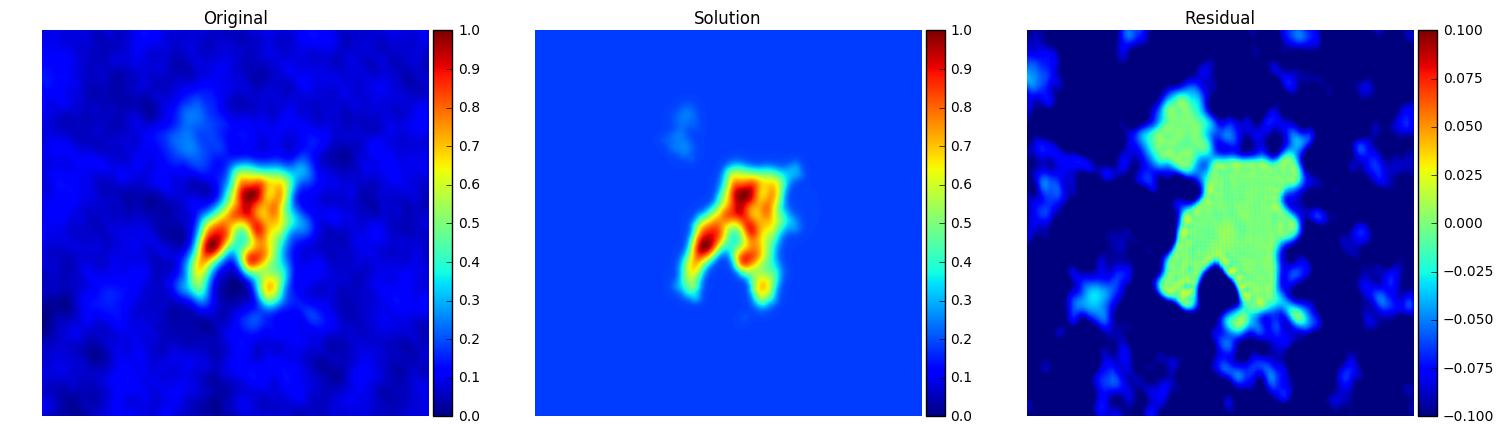

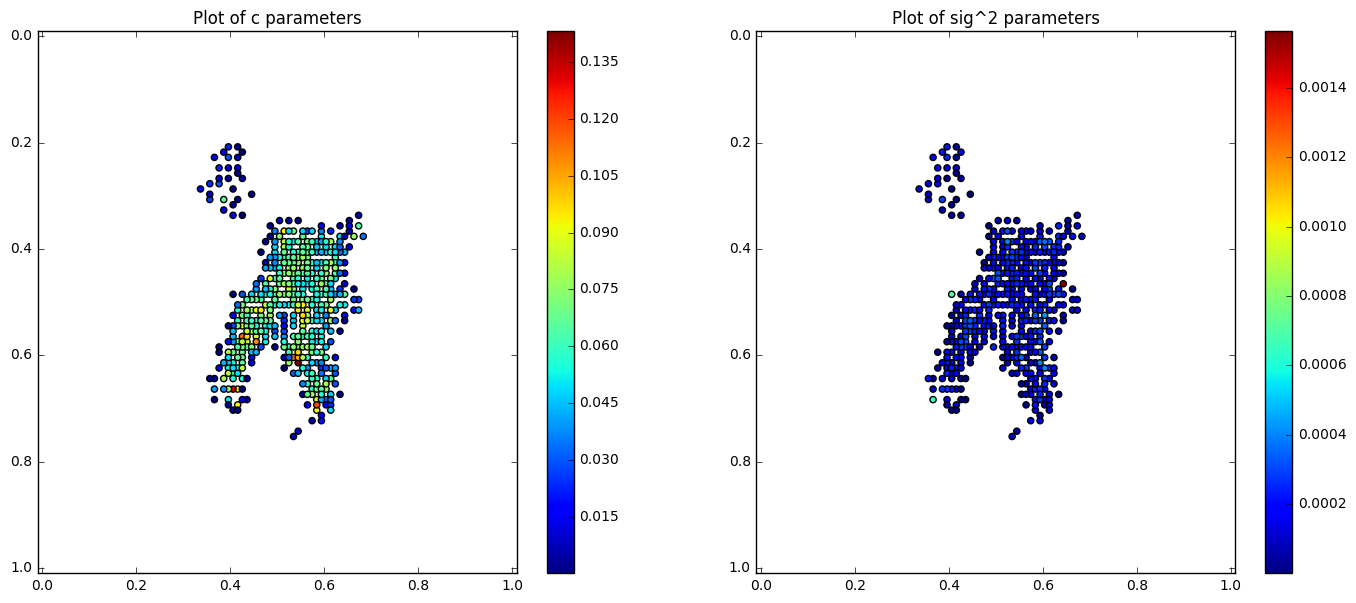

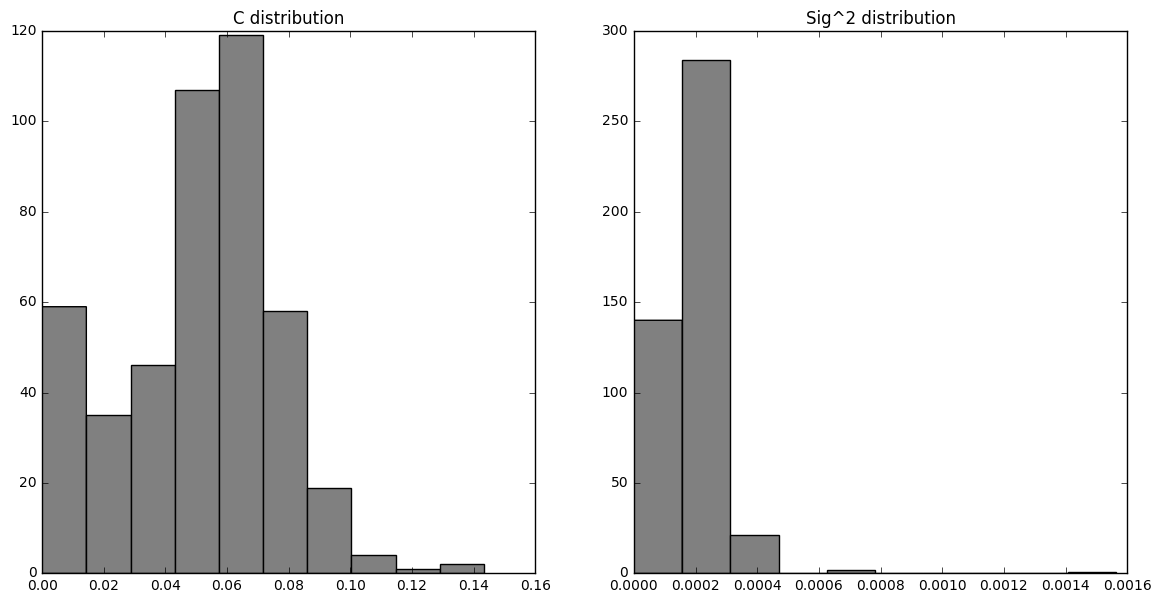

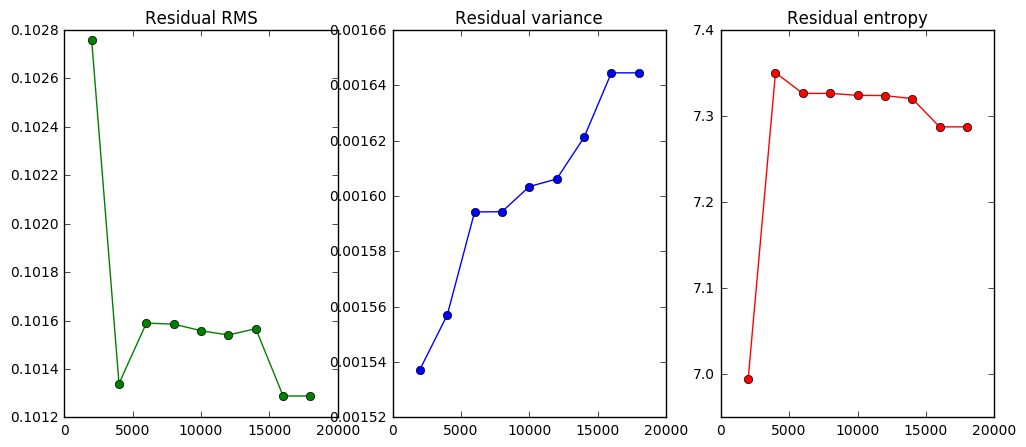

In [6]:
el_solver(elf08, method='exact', base_level=estimate_rms(data), square_c=True, step_iter=2000, max_iter=50000)

## Visualizing the level sets

In [7]:
def level_set_plot(data, level):
    plt.figure(figsize=(5,5))
    ax = plt.gca()
    _data = np.zeros(data.shape)
    mask = data > level
    _data[mask] = data[mask]
    im = ax.imshow(_data)
    plt.title('Center points plot')
    plt.axis('off')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.08)
    plt.colorbar(im, cax=cax)
    plt.show()

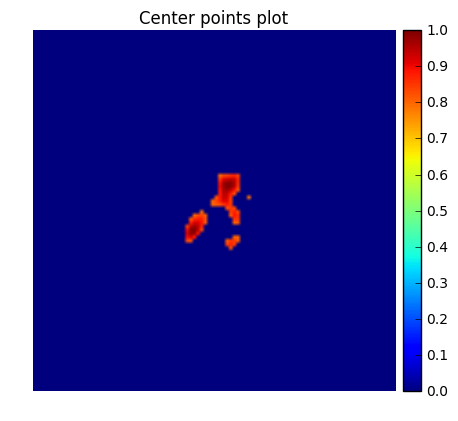

In [9]:
interact(level_set_plot, data=fixed(data), level=(base_level, 1.))